In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as stats


In [2]:

variants = 40
total = 300


def log_likelihood(theta, k, n):
    """
    Computes the log-likelihood for a binomial model.

    Parameters:
    theta (float): Probability of success (proportion carrying the variant)
    k (int): Number of successes (individuals with the variant)
    n (int): Total number of trials (tested individuals)

    Returns:
    float: Log-likelihood value
    """
    if theta <= 0 or theta >= 1:
        return -np.inf  # Log-likelihood is undefined for theta outside (0,1)

    log_likelihood_value = k * np.log(theta) + (n - k) * np.log(1 - theta)
    return log_likelihood_value

# Example usage:
k = 40  # Number of people with the variant
n = 300  # Total tested
theta_test = 0.1  # Example probability of the variant


y is the vector of observed values according to the chosen theta
rtheta is a vactor storing draws from a beta prior (probability estimates)


Summary
𝑟
𝑡
ℎ
𝑒
𝑡
𝑎
rtheta represents 
𝑃
(
𝜃
)
P(θ), the prior on the variant frequency.

𝑦
y represents 
𝑃
(
𝐷
∣
𝜃
)
P(D∣θ), the likelihood of observing data given a particular 
𝜃
θ.

Bayes' Theorem combines these to compute 
𝑃
(
𝜃
∣
𝐷
)
P(θ∣D), our posterior belief about 
𝜃
θ after seeing the data.

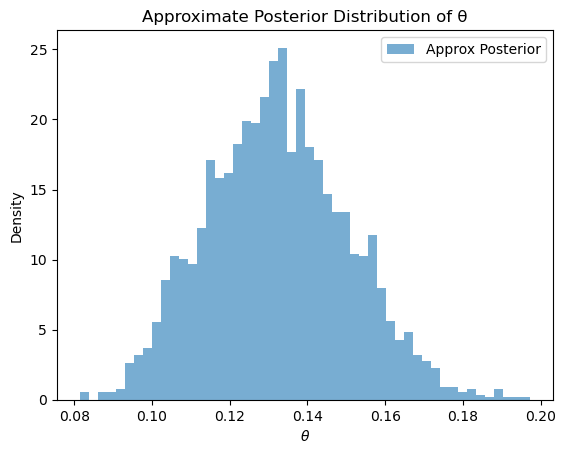

[0.13320488 0.1344776  0.1155885  0.11125733 0.14142366 0.13837064
 0.12914494 0.13533061 0.14935759 0.10759608]


In [3]:
# Define theta range
thetas = np.arange(0, 1.001, 0.001)  # Equivalent to seq(0,1,by=0.001) in R
theta = thetas[:500]

# Compute Beta densities for different priors
dfbetas = pd.DataFrame({
    'theta': theta,
    'db1': stats.beta.pdf(theta, 1, 7),
    'db2': stats.beta.pdf(theta, 5, 35),
    'db3': stats.beta.pdf(theta, 50, 350)
})

# Simulate prior samples from Beta(5,35)
np.random.seed(42)  # For reproducibility
rtheta = np.random.beta(a=5, b=35, size=100000)

# Simulate observed data y given rtheta
y = np.random.binomial(n=300, p=rtheta, size=len(rtheta))

# Condition on observed data (approximate posterior)
yobs = 40  # Example observed count (analogous to the real-world data)
posterior_samples = rtheta[y == yobs]  # Subset of rtheta where y == observed data

# Visualize the approximated posterior
plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, label="Approx Posterior")
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Approximate Posterior Distribution of θ")
plt.legend()
plt.show()

# Print first few posterior samples for verification
print(posterior_samples[:10])

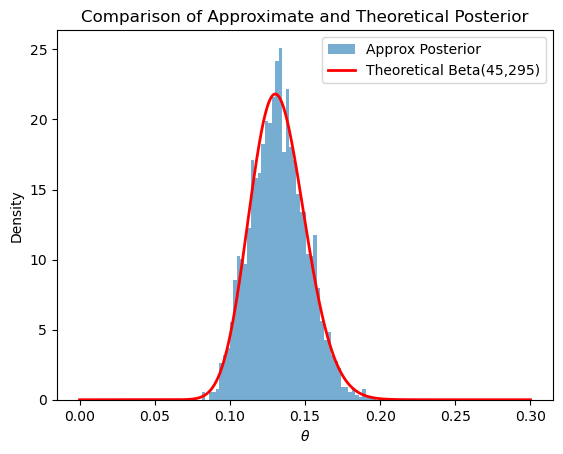

In [4]:
# Define a theta grid for the theoretical posterior
theta_grid = np.linspace(0, 0.3, 1000)  # Focusing on relevant range

# Compute the theoretical posterior density
posterior_density = stats.beta.pdf(theta_grid, 45, 295)

# Plot the approximate posterior (histogram)
plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, label="Approx Posterior")

# Plot the theoretical posterior (Beta distribution)
plt.plot(theta_grid, posterior_density, color='red', lw=2, label="Theoretical Beta(45,295)")

# Labels and title
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Comparison of Approximate and Theoretical Posterior")
plt.legend()

# Show the plot
plt.show()


In [5]:
# Compute probabilities from posterior samples
p_less_than_10 = np.mean(posterior_samples < 0.10)  # P(θ < 0.10)
p_more_than_20 = np.mean(posterior_samples > 0.20)  # P(θ > 0.20)

# Print results
print(f"Posterior probability that θ < 10%: {p_less_than_10:.4f}")
print(f"Posterior probability that θ > 20%: {p_more_than_20:.4f}")


Posterior probability that θ < 10%: 0.0276
Posterior probability that θ > 20%: 0.0000


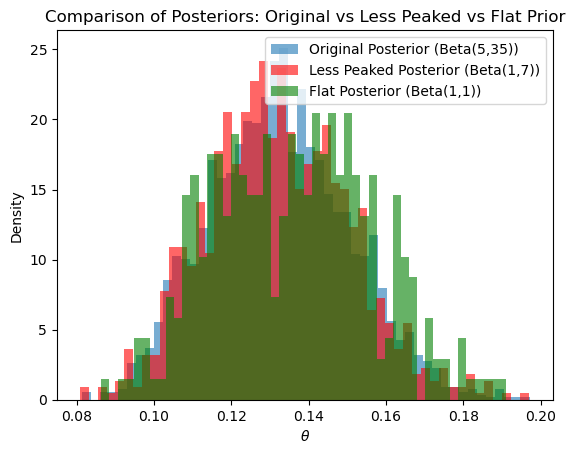

Original P(θ < 10%): 0.0276, Less Peaked P(θ < 10%): 0.0307, Flat P(θ < 10%): 0.0275
Original P(θ > 20%): 0.0000, Less Peaked P(θ > 20%): 0.0000, Flat P(θ > 20%): 0.0000


In [6]:
# New less peaked prior: Beta(1,7)
np.random.seed(42)  # For reproducibility
rtheta_less_peaked = np.random.beta(a=1, b=7, size=100000)

# New flat prior: Beta(1,1) (Uniform prior)
rtheta_flat = np.random.beta(a=1, b=1, size=100000)

# Generate observed data y given the new priors
y_less_peaked = np.random.binomial(n=300, p=rtheta_less_peaked, size=len(rtheta_less_peaked))
y_flat = np.random.binomial(n=300, p=rtheta_flat, size=len(rtheta_flat))

# Approximate posterior by conditioning on y = 40
posterior_samples_less_peaked = rtheta_less_peaked[y_less_peaked == 40]
posterior_samples_flat = rtheta_flat[y_flat == 40]

# Plot comparison of posteriors
plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, label="Original Posterior (Beta(5,35))")
plt.hist(posterior_samples_less_peaked, bins=50, density=True, alpha=0.6, label="Less Peaked Posterior (Beta(1,7))", color='red')
plt.hist(posterior_samples_flat, bins=50, density=True, alpha=0.6, label="Flat Posterior (Beta(1,1))", color='green')

plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Comparison of Posteriors: Original vs Less Peaked vs Flat Prior")
plt.legend()
plt.show()

# Compute probabilities with the new priors
p_less_than_10_less_peaked = np.mean(posterior_samples_less_peaked < 0.10)
p_more_than_20_less_peaked = np.mean(posterior_samples_less_peaked > 0.20)

p_less_than_10_flat = np.mean(posterior_samples_flat < 0.10)
p_more_than_20_flat = np.mean(posterior_samples_flat > 0.20)

# Print results
print(f"Original P(θ < 10%): {p_less_than_10:.4f}, Less Peaked P(θ < 10%): {p_less_than_10_less_peaked:.4f}, Flat P(θ < 10%): {p_less_than_10_flat:.4f}")
print(f"Original P(θ > 20%): {p_more_than_20:.4f}, Less Peaked P(θ > 20%): {p_more_than_20_less_peaked:.4f}, Flat P(θ > 20%): {p_more_than_20_flat:.4f}")
